# imports y funciones 

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import json



def load_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        config = json.load(f)
    return config

def load_data_and_labels(dataset_name):
    cwd = os.getcwd()
    config_path = os.path.join(cwd, 'data_config.json')
    config = load_config(config_path)

    data_info = config[dataset_name]
    sr = data_info['sr']
    seq_len = data_info['seq_len']
    dimension = data_info['dimension']
    activity_label_index = data_info['activity_label_index']
    activity_label = data_info['activity_label']
    user_label_index = data_info.get('user_label_index')
    user_label = data_info.get('user_label')
    
    data_file = f'data_{sr}_{seq_len}.npy'
    label_file = f'label_{sr}_{seq_len}.npy'
    
    dataset_folder = dataset_name.split('_')[0]
    data_path = os.path.join(cwd,  dataset_folder, data_file)
    label_path = os.path.join(cwd,  dataset_folder, label_file)

    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    data = np.load(data_path)
    labels = np.load(label_path)
    
    return data, labels, activity_label_index, activity_label, user_label_index, user_label



def plot_data(df, start_second=None, end_second=None, figsize=(12, 8), show_milliseconds=False):
    if start_second is None:
        start_second = df['Time (s)'].min()
    if end_second is None:
        end_second = df['Time (s)'].max()

    df_filtered = df[(df['Time (s)'] >= start_second) & (df['Time (s)'] <= end_second)]

    plt.figure(figsize=figsize)
    
    for i in range(1, df.shape[1] - 1):  # Excluye la columna 'Activity'
        plt.subplot(3, 2, i)
        for activity in df['Activity'].unique():
            activity_data = df_filtered[df_filtered['Activity'] == activity]
            plt.plot(activity_data['Time (s)'], activity_data[f'DOF{i}'], label=activity)
        plt.title(f'DOF{i}')
        plt.xlabel('Time (s)')
        plt.ylabel(f'DOF{i}')
        plt.legend()

        # Agregar marcas temporales en segundos y opcionalmente en milisegundos
        plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}s' for x in plt.xticks()[0]])
        if show_milliseconds:
            plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}s ({x*1000:.0f}ms)' for x in plt.xticks()[0]])

    plt.tight_layout()
    plt.show()

def create_dataframe(data, labels, activity_label_index, activity_label):
    n_samples, n_windows, n_features = data.shape
    time_index = np.arange(n_samples * n_windows) / (n_windows // 10)  # Calcula los tiempos en segundos
    
    # Aplanar los datos y las etiquetas
    flattened_data = data.reshape(n_samples * n_windows, n_features)
    flattened_labels = labels.reshape(n_samples * n_windows, -1)
    
    # Crear el DataFrame con los datos y las etiquetas
    df = pd.DataFrame(flattened_data, columns=[f'DOF{i+1}' for i in range(n_features)])
    df['Time (s)'] = time_index
    df['Activity'] = [activity_label[int(label)] for label in flattened_labels[:, activity_label_index]]
    
    return df

def plot_labels(df, start_second=None, end_second=None, figsize=(12, 8), label_column='Activity'):
    if start_second is None:
        start_second = df['Time (s)'].min()
    if end_second is None:
        end_second = df['Time (s)'].max()

    df_filtered = df[(df['Time (s)'] >= start_second) & (df['Time (s)'] <= end_second)]

    unique_labels = df_filtered[label_column].unique()
    num_labels = len(unique_labels)

    plt.figure(figsize=figsize)

    for i, label in enumerate(unique_labels, 1):
        label_data = df_filtered[df_filtered[label_column] == label]

        # Subgráfico para el acelerómetro (3 DOF)
        plt.subplot(num_labels, 2, 2*i-1)
        plt.plot(label_data['Time (s)'], label_data['DOF1'], label=f'{label} - DOF1')
        plt.plot(label_data['Time (s)'], label_data['DOF2'], label=f'{label} - DOF2')
        plt.plot(label_data['Time (s)'], label_data['DOF3'], label=f'{label} - DOF3')
        plt.title(f'{label} - Acelerómetro (3 DOF)')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration')
        plt.legend()

        # Subgráfico para el giroscopio (3 DOF)
        plt.subplot(num_labels, 2, 2*i)
        plt.plot(label_data['Time (s)'], label_data['DOF4'], label=f'{label} - DOF4')
        plt.plot(label_data['Time (s)'], label_data['DOF5'], label=f'{label} - DOF5')
        plt.plot(label_data['Time (s)'], label_data['DOF6'], label=f'{label} - DOF6')
        plt.title(f'{label} - Giroscopio (3 DOF)')
        plt.xlabel('Time (s)')
        plt.ylabel('Angular Velocity')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_activity(df, activity, start_second=None, end_second=None, figsize=(12, 8)):
    if start_second is None:
        start_second = df['Time (s)'].min()
    if end_second is None:
        end_second = df['Time (s)'].max()

    df_filtered = df[(df['Time (s)'] >= start_second) & (df['Time (s)'] <= end_second) & (df['Activity'] == activity)]

    plt.figure(figsize=figsize)

    # Subgráfico para el acelerómetro (3 DOF)
    plt.subplot(2, 1, 1)
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF1'], label=f'{activity} - DOF1')
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF2'], label=f'{activity} - DOF2')
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF3'], label=f'{activity} - DOF3')
    plt.title(f'{activity} - Acelerómetro (3 DOF)')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration')
    plt.legend()

    # Establecer límites de ejes x para mostrar solo las marcas de tiempo relevantes
    plt.xlim(start_second, end_second)

    # Subgráfico para el giroscopio (3 DOF)
    plt.subplot(2, 1, 2)
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF4'], label=f'{activity} - DOF4')
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF5'], label=f'{activity} - DOF5')
    plt.plot(df_filtered['Time (s)'], df_filtered['DOF6'], label=f'{activity} - DOF6')
    plt.title(f'{activity} - Giroscopio (3 DOF)')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity')
    plt.legend()

    # Establecer límites de ejes x para mostrar solo las marcas de tiempo relevantes
    plt.xlim(start_second, end_second)

    plt.tight_layout()
    plt.show()


# carga de data set y descripcion

In [6]:
file_path=r"dataset\data_config.json"

# Ejemplo de uso
dataset_name = 'hhar_20_120'  # Reemplaza con el nombre del dataset que quieras cargar
data, labels, activity_label_index, activity_label, user_label_index, user_label = load_data_and_labels(dataset_name)


df = create_dataframe(data, labels, activity_label_index, activity_label)
print(df.describe())


               DOF1          DOF2          DOF3          DOF4          DOF5  \
count  1.099920e+06  1.099920e+06  1.099920e+06  1.099920e+06  1.099920e+06   
mean  -1.525066e+00  2.187745e-01  8.809486e+00  2.850303e-03 -9.710755e-03   
std    3.926586e+00  1.452380e+00  2.170929e+00  4.341862e-01  4.017108e-01   
min   -2.564160e+01 -1.055931e+01 -7.201227e+00 -3.108543e+00 -5.837543e+00   
25%   -3.959517e+00 -5.841852e-01  7.641095e+00 -1.042442e-01 -1.040344e-01   
50%   -2.050634e+00  1.915361e-01  8.992081e+00 -4.276057e-04 -2.975464e-03   
75%    2.468903e-01  1.012952e+00  9.794821e+00  1.240807e-01  8.930850e-02   
max    1.598752e+01  1.141938e+01  2.975201e+01  5.444489e+00  9.812119e+00   

               DOF6      Time (s)  
count  1.099920e+06  1.099920e+06  
mean  -1.212769e-02  4.582996e+04  
std    4.741326e-01  2.645997e+04  
min   -3.709961e+00  0.000000e+00  
25%   -1.506348e-01  2.291498e+04  
50%   -1.282817e-03  4.582996e+04  
75%    1.063261e-01  6.874494e+04  


# ploters basicos

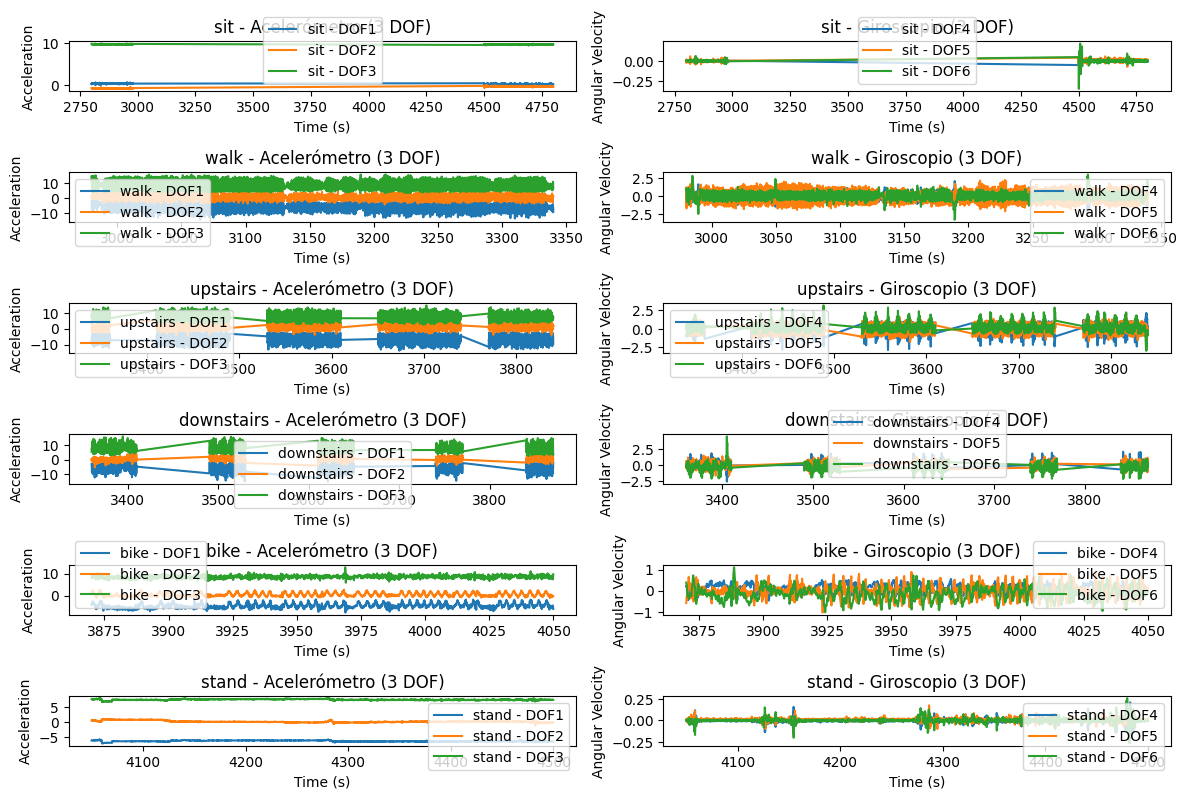

In [9]:
#esta funcion no es buena ploteando todo el dataSet (ya que comprime tiempo)
inicio = 2800
tiempo = 2000
fin=inicio+ tiempo

plot_labels(df, inicio,fin)

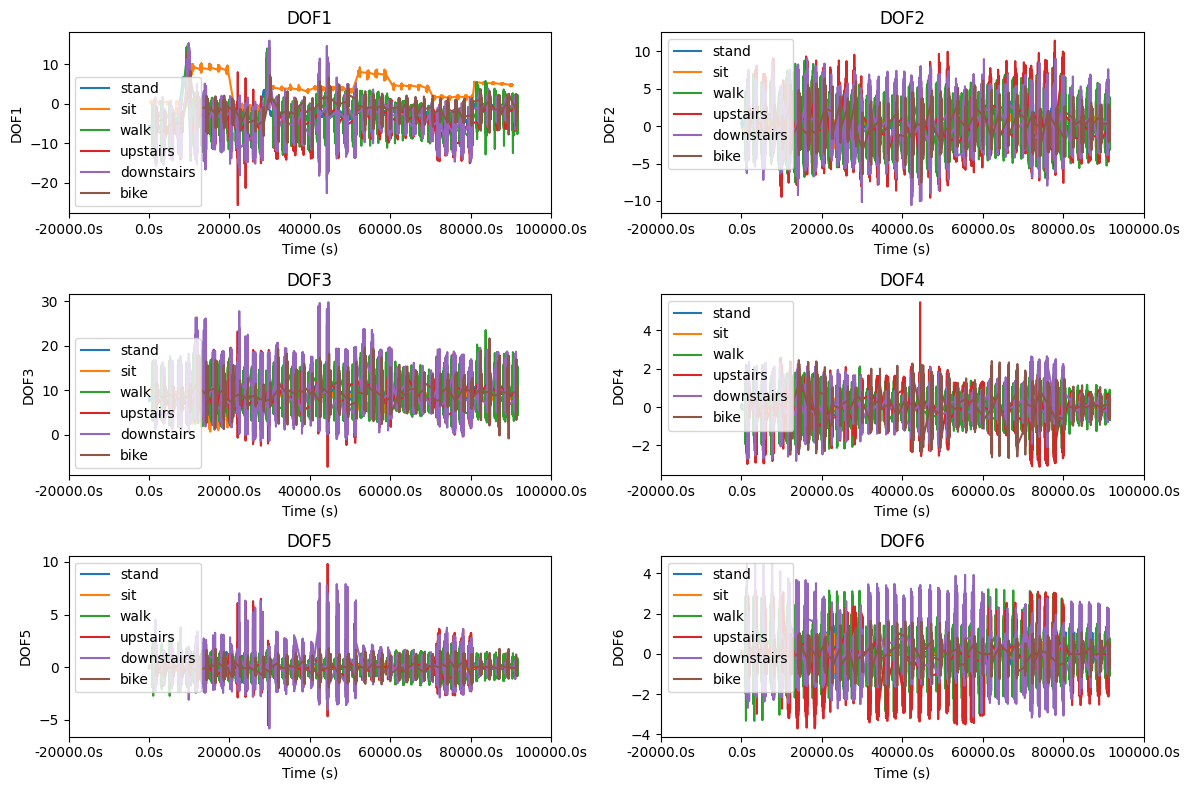

In [10]:

plot_data(df)